In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
df_rxn_rates = pd.read_csv('Org_reactions_rates.csv')

Pearson_Absmax_all = []

csv_name_to_save_XY = 'prediction_results_student35.csv'
XY_for_plot = []

for csv_name in ['prediction_results_teacher.csv', 'prediction_results_student.csv'] + \
    sorted(glob.glob("prediction_results_student?.csv")) + \
    sorted(glob.glob("prediction_results_student??.csv")) + \
    sorted(glob.glob("prediction_results_control_student?.csv")) + \
    sorted(glob.glob("prediction_results_control_student??.csv")):
    Pearson_coeffs_eachrxn = []
    df = pd.read_csv(csv_name)
    df_rxns, df_logP = df[~df.comment.str.contains('set')], df[df.comment.str.contains('set')]
    df_rxns['rxn_code'] = [  '-'.join(x.split('-')[0:-1]) for x in df_rxns['comment'] ]

    Rxn_names_all = []
    
    rxn_group = 'PR'
    #rxn_group = 'P'
    #rxn_group = 'R'
    
    
    bad_rxns = ['5-26', '5-36','JPOC2012-Table2','JACS1988-Table1',
                '5-42','NatChem_2013','GreenChem_2016-Fig2','GreenChem_2016-Fig4', 
                'CES_2015','5-45','5-34','5-32','5-30','Menschutkin_table5-5','5-13'] # 5-36 in the chemrxiv paper
    
    if rxn_group == 'PR':
        #rxns_of_interest = ['5-50', 'ChemPhysChem2014-Fig5','5-49','5-48']
        rxns_of_interest = ['5-36', '5-50', 'ChemPhysChem2014-Fig5', '5-49']# in the chemrxiv paper
        # 5-48 (Wittig) got bad???
        
    elif rxn_group == 'P':
        rxns_of_interest = ['t-butylperoxy-Fig11','IJCK2016-TableI','5-44']
        
        
    elif rxn_group == 'R':
        rxns_of_interest = ['5-14','IJCK2016-TableII','5-29', 'Cp-DielsAlder-table5-1']
    
    #for SI
    rxns_of_interest = ['t-butylperoxy-Fig11','IJCK2016-TableI','5-44', 
                         '5-14','IJCK2016-TableII','5-29', 'Cp-DielsAlder-table5-1',
                          '5-36', '5-50', 'ChemPhysChem2014-Fig5', '5-49']
    
    #for rxn_name, df_rxn in df_rxns.groupby('rxn_code'):
    for rxn_name in rxns_of_interest:
        df_rxn = df_rxns[df_rxns['rxn_code'] == rxn_name]
        
        Rxn_names_all.append(rxn_name)
        #print(rxn_name)
        if rxn_name == '5-50' or rxn_name == 'ChemPhysChem2014-Fig5':
            df_rxn = df_rxn[df_rxn.comment != rxn_name + '-P2']
            df_rxn.loc[(df_rxn.comment == rxn_name + '-P1'), 'comment'] = rxn_name + '-P'

        R_IM_P_types = set([  x.split('-')[-1]   for x in list(df_rxn.comment.unique())])

        DGsolv_R = []
        if  len(set(['R', 'P']) - R_IM_P_types) == 0:
            DGsolv_P = []
            DGsolv_RP = []
            DGsolv_PR = []
            if len(set(['R', 'IM', 'P']) - R_IM_P_types) == 0:
                DGsolv_IM = []
                DGsolv_IMR = []
            ln_krel_P = []

        else:
            DGsolv_P1 = []
            DGsolv_P2 = []
            DGsolv_RP1 = []
            DGsolv_RP2 = []
            DGsolv_P1R = []
            DGsolv_P2R = []
            ln_krel_P1 = []
            ln_krel_P2 = []

        for solvent_smi, df_each_solvent in df_rxn.groupby('can_smiles_solvent'):
            dgsolv_R = sum(df_each_solvent[df_each_solvent['comment'] == rxn_name + '-R' ]['predicted'])

            if len(set(['R', 'P']) - R_IM_P_types) == 0:
                ln_krel = df_rxn_rates[(df_rxn_rates['P_notation'] == rxn_name+'-P') & 
                                              (df_rxn_rates['can_smiles_solvent'] == solvent_smi)]['ln_krel'].iloc[0]
                if np.isnan(ln_krel):
                    continue
                ln_krel_P.append(ln_krel)            
                dgsolv_P = sum(df_each_solvent[df_each_solvent['comment'] == rxn_name + '-P' ]['predicted'])
                
                if rxn_name == 'Cp-DielsAlder-table5-1':
                    DGsolv_R.append(2*dgsolv_R)
                else:
                    DGsolv_R.append(dgsolv_R)
                
                
                DGsolv_P.append(dgsolv_P)
                DGsolv_RP.append(dgsolv_R + dgsolv_P)
                
                if rxn_name == 'Cp-DielsAlder-table5-1':
                    #DGsolv_PR.append(dgsolv_P - 2 * dgsolv_R)
                    DGsolv_PR.append(dgsolv_P - dgsolv_R)
                else:
                    DGsolv_PR.append(dgsolv_P - dgsolv_R)

                if len(set(['R', 'IM', 'P']) - R_IM_P_types) == 0:
                    dgsolv_IM = sum(df_each_solvent[df_each_solvent['comment'] == rxn_name + '-IM' ]['predicted'])
                    DGsolv_IM.append(dgsolv_IM)
                    DGsolv_IMR.append(dgsolv_IM - dgsolv_R)

            else:
                ln_krel_p1 = df_rxn_rates[(df_rxn_rates['P_notation'] == rxn_name+'-P1') & 
                                          (df_rxn_rates['can_smiles_solvent'] == solvent_smi)]['ln_krel'].iloc[0]
                ln_krel_p2 = df_rxn_rates[(df_rxn_rates['P_notation'] == rxn_name+'-P2') & 
                                          (df_rxn_rates['can_smiles_solvent'] == solvent_smi)]['ln_krel'].iloc[0]

                ln_krel_P1.append(ln_krel_p1)
                ln_krel_P2.append(ln_krel_p2)


                dgsolv_P1 = sum(df_each_solvent[df_each_solvent['comment'] == rxn_name + '-P1' ]['predicted'])
                dgsolv_P2 = sum(df_each_solvent[df_each_solvent['comment'] == rxn_name + '-P2' ]['predicted'])

                DGsolv_R.append(dgsolv_R)
                DGsolv_P1.append(dgsolv_P1)
                DGsolv_RP1.append(dgsolv_R + dgsolv_P1)
                DGsolv_P1R.append(dgsolv_P1 - dgsolv_R)            
                DGsolv_P2.append(dgsolv_P2)
                DGsolv_RP2.append(dgsolv_R + dgsolv_P2)
                DGsolv_P2R.append(dgsolv_P2 - dgsolv_R) 

        if len(set(['R', 'P']) - R_IM_P_types) == 0:
            if rxn_group == 'PR':
                X_arrays = [DGsolv_PR]
            elif rxn_group == 'P':
                X_arrays = [DGsolv_P]
            elif rxn_group == 'R':
                X_arrays = [DGsolv_R]

            if len(set(['R', 'IM', 'P']) - R_IM_P_types) == 0:
                if rxn_group == 'PR':
                    X_arrays = [DGsolv_IMR]
                elif rxn_group == 'P':
                    X_arrays = [DGsolv_IM]
                elif rxn_group == 'R':
                    X_arrays = [DGsolv_R]
            Pearson_coeffs_eachrxn.append([np.corrcoef(x, ln_krel_P)[0][1] for x in X_arrays])
        else:
            #X_arrays1 = [DGsolv_R, DGsolv_P1, DGsolv_RP1, DGsolv_P1R]
            #X_arrays2 = [DGsolv_R, DGsolv_P2, DGsolv_RP2, DGsolv_P2R]
            
            if rxn_group == 'PR':
                X_arrays1 = [DGsolv_P1R]
                X_arrays2 = [DGsolv_P2R]
            elif rxn_group == 'P':
                X_arrays1 = [DGsolv_P1]
                X_arrays2 = [DGsolv_P2]
            elif rxn_group == 'R':
                X_arrays1 = [DGsolv_R]
                X_arrays2 = [DGsolv_R]
            Pearson_coeffs_eachrxn.append([np.corrcoef(x, ln_krel_P1)[0][1] for x in X_arrays1])
            Pearson_coeffs_eachrxn.append([np.corrcoef(x, ln_krel_P2)[0][1] for x in X_arrays2])

        
        if csv_name == csv_name_to_save_XY:
            XY_for_plot.append(np.array([X_arrays[0], ln_krel_P]).T)

    Pearson_absmax = []    
    for rho in Pearson_coeffs_eachrxn:
        #Pearson_absmax.append(max([abs(x) for x in rho]))
        Pearson_absmax.append(max([x for x in rho]))
    Pearson_Absmax_all.append(Pearson_absmax)
    
    #print(Rxn_names_all)
        

/Users/kyj/opt/anaconda3/envs/ykim/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [3]:
Pearson_Absmax_all_by_students = np.array(Pearson_Absmax_all).T
Pearson_Absmax_all_by_students.shape

(11, 65)

In [4]:
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300


#colors = ['black', 'peru', 'blue', 'teal']
colors = ['black', 'black', 'black', 'black']
for i, pearson_array in enumerate(Pearson_Absmax_all_by_students):
    
    if i == 3:
        plt.plot(range(1,31),Pearson_Absmax_all_by_students[i][1:31], alpha = 1.0, label = rxns_of_interest[i], color = 'blue')
        plt.scatter(range(1,31),Pearson_Absmax_all_by_students[i][1:31], s=20, alpha = 1.0, color = 'blue')


        plt.plot(range(1,29),Pearson_Absmax_all_by_students[i][31:], '--', alpha = 0.5, label = rxns_of_interest[i], color= colors[i])
        plt.scatter(range(1,29),Pearson_Absmax_all_by_students[i][31:], s=20, alpha = 0.5, color = colors[i])


        plt.plot([0,31],[Pearson_Absmax_all_by_students[i][0],Pearson_Absmax_all_by_students[i][0]], '--',  alpha = 1.0, color='teal' )
        plt.tight_layout()
        
        plt.xlabel('Student # (0: Teacher)')
        plt.ylabel('Pearson rho')

    
#plt.plot([14,14],[np.amin(Pearson_Absmax_all_by_students), np.amax(Pearson_Absmax_all_by_students)], '--',  alpha = 0.3 )

'''
if rxn_group != 'R':
    plt.plot([14,14],[-1,-0.5], '--',  alpha = 0.3 )
else:
    plt.plot([14,14],[0.5,1], '--',  alpha = 0.3 )
'''
#plt.legend()
#plt.plot([0,36], [Pearson_Absmax_all_by_students[4][14],Pearson_Absmax_all_by_students[4][14]])


In [5]:
XY_for_plot

[array([[ 0.89657173,  0.        ],
        [-0.165241  ,  4.70048037],
        [ 1.02511487,  1.38629436],
        [ 1.16599995,  3.40119738],
        [ 0.4250402 ,  4.94164242],
        [ 0.9587594 ,  2.63905733]]),
 array([[ 3.312902  ,  4.69134788],
        [ 2.99172   ,  4.9698133 ],
        [ 1.860852  ,  3.04452244],
        [ 2.180039  ,  3.93182563],
        [-0.9879696 ,  0.        ]]),
 array([[2.2486526 , 1.16315081],
        [3.058542  , 0.64185389],
        [2.535069  , 0.78845736],
        [2.740616  , 0.        ],
        [3.2874853 , 0.64185389],
        [1.6770665 , 1.7227666 ]]),
 array([[0.1199744 , 5.29831737],
        [0.1240887 , 6.41345896],
        [0.0294805 , 2.99573227],
        [0.1161923 , 4.17438727]]),
 array([[ 1.6181224 ,  0.        ],
        [ 1.0918313 ,  0.16653769],
        [ 0.176322  ,  0.44279107],
        [-0.1975579 ,  0.38054876]]),
 array([[-0.568317  ,  3.93182563],
        [ 0.1557675 ,  8.48879372],
        [ 0.0265868 , 11.98292909],
  

-0.6271096335912082
0.9891669548894063
-0.7584811284300339
0.8249716034334186
-0.9493045446561494
-0.5935886611032778
0.9408977378749939
-0.9904922618032096
-0.9489760469647869
-0.7983956546202704
-0.8395022741023022


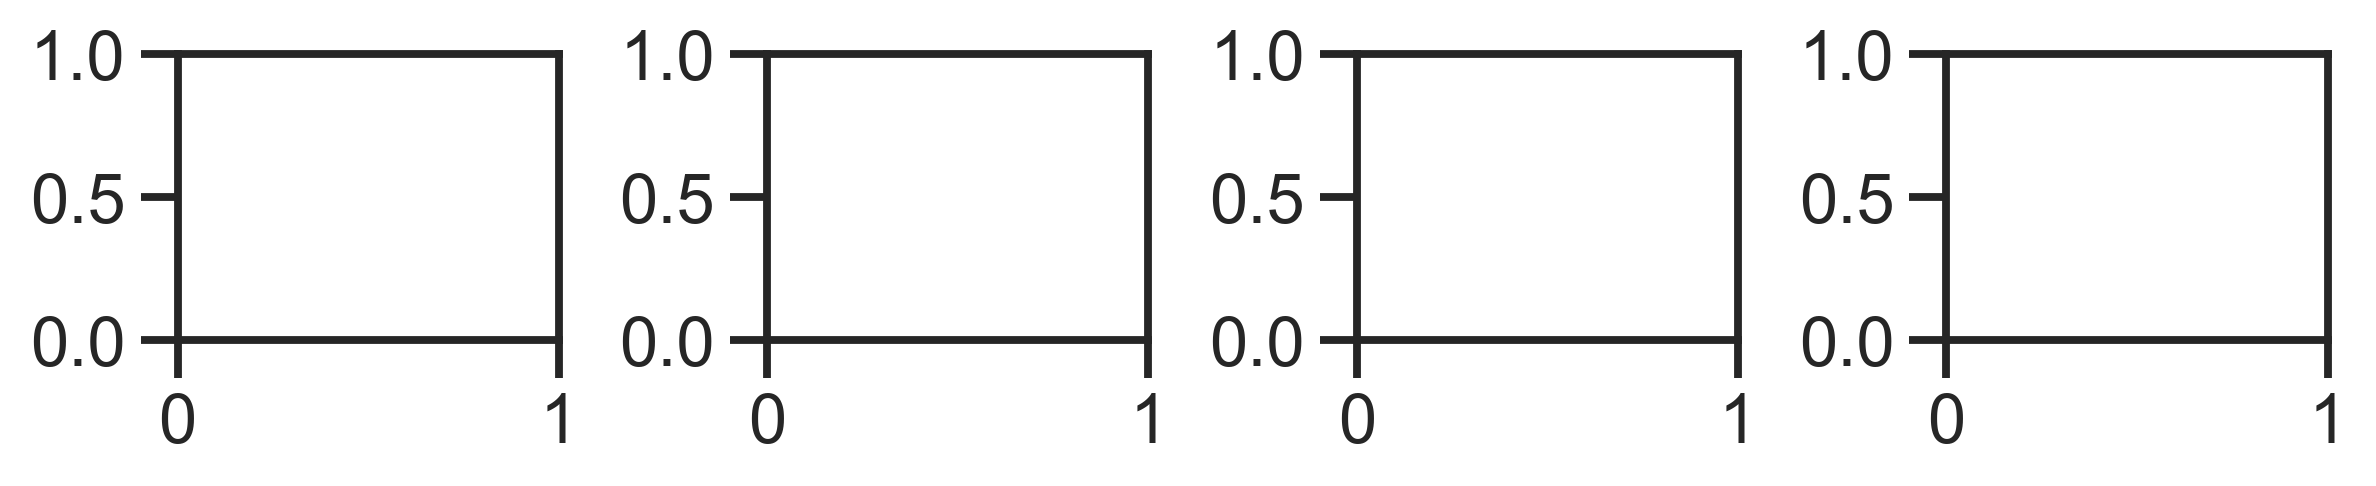

In [6]:
from matplotlib.ticker import FormatStrFormatter


#fig, axmatrix = plt.subplots(nrows=4, figsize=(2,7), sharex=False, sharey=False)
fig, axmatrix = plt.subplots(ncols=4, figsize=(8,1.7), sharex=False, sharey=False)

count = 0


#PR

colors = ['darkgreen', 'saddlebrown', 'firebrick', 'navy']
X_ticks = [
    [0.0, 0.1, 0.2],
    [-2.0, -1.0, 0.0],
    [1,2,3],
    [-1.2, -0.8, -0.4],
]



Y_ticks = [
    [0,2,4,6],
    [0,1.2,2.4,3.6],
    [0,1,2],
    [0, 0.4, 0.8, 1.2],
]


#P
'''
colors = ['olive', 'olivedrab', 'darkcyan', 'black']

X_ticks = [
    [-6, -4.5, -3],
    [-22.0, -19.0, -16.0],
    [-13.0, -12.5, -12.0],
    [0,1],
]


Y_ticks = [
    [0,2.5,5],
    [0,2.5,5],
    [0, 0.6, 1.2, 1.8],
    [0, 1],
]
'''

#R
'''
colors = ['indigo', 'blue', 'steelblue', 'mediumvioletred']
X_ticks = [
    [-7, -6.5, -6],
    [-25.0, -22.5, -20.0],
    [-7, -4, -1],
    [-7.2, -6.8, -6.4],
]

Y_ticks = [
    [3.0, 4.7, 6.4],
    [0,0.2,0.4],
    [0, 8, 16, 24  ],
    [0,.4,.8,1.2],
    
    
]
'''

'''
X_lims = [
    [-0.5,0.02],
    [-1.7,0.02],
    [0.9, 3.1],
    [0.68, 1.02],
    [-1.3, 0.4]
]
Y_lims = [
    [-.5,6.5],
    [-.3,4],
    [-.2,2.2],
    [0.1,1.3],
    [-.3,4.2]
    
]
'''

for XY in XY_for_plot:
    '''
    axmatrix[count].plot(XY[:,0], XY[:,1], '.', ms=10, alpha=1.0, color=colors[count])
    axmatrix[count].tick_params(labelsize=12)
    axmatrix[count].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axmatrix[count].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    [x.set_linewidth(1.0) for x in axmatrix[count].spines.values()]
    axmatrix[count].xaxis.set_tick_params(width=1.0)
    axmatrix[count].yaxis.set_tick_params(width=1.0)
    axmatrix[count].spines['top'].set_visible(False)
    axmatrix[count].spines['right'].set_visible(False)
    
    axmatrix[count].set_xticks(X_ticks[count])
    axmatrix[count].set_yticks(Y_ticks[count])
    #axmatrix[count].set_xlim(X_lims[count])
    #axmatrix[count].set_ylim(Y_lims[count])
    axmatrix[count].tick_params(axis='both', which='major', labelsize=10)
    axmatrix[count].tick_params(axis='both', which='minor', labelsize=10)
    
    count +=1
    '''
    print(np.corrcoef(XY[:,0],XY[:,1])[0][1])

    
fig.tight_layout(pad=1.0)